# MNIST
The MNIST dataset is a set of 60,000 handwritten numbers with their labels. This exercise will use this dataset as a way to explore how to use PyTorch.

## Libraries
- **PyTorch** 
- **MNIST** for the dataset
- **NumPy** for data manipulation
- **Matplotlib** for visualisation
- **scikit-learn** for metrics

In [1]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(), #Convert to tensor and normalise
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [2]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 60000
Test dataset size: 10000


Visualise the dataset

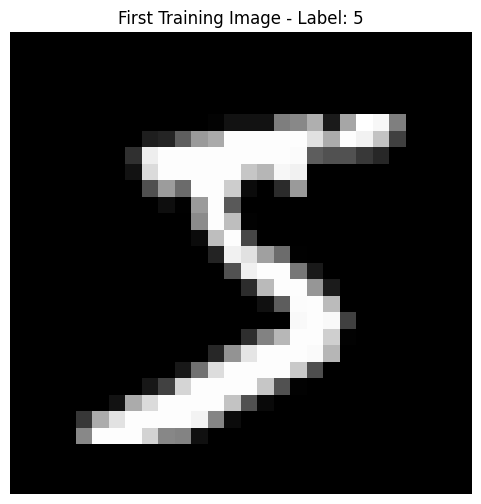

In [3]:
import matplotlib.pyplot as plt
import numpy as np

first_image, first_label = train_dataset[0]
first_image_np = first_image.squeeze().numpy()

plt.figure(figsize=(6,6))
plt.imshow(first_image_np, cmap='grey')
plt.title(f"First Training Image - Label: {first_label}")
plt.axis('off')
plt.show()

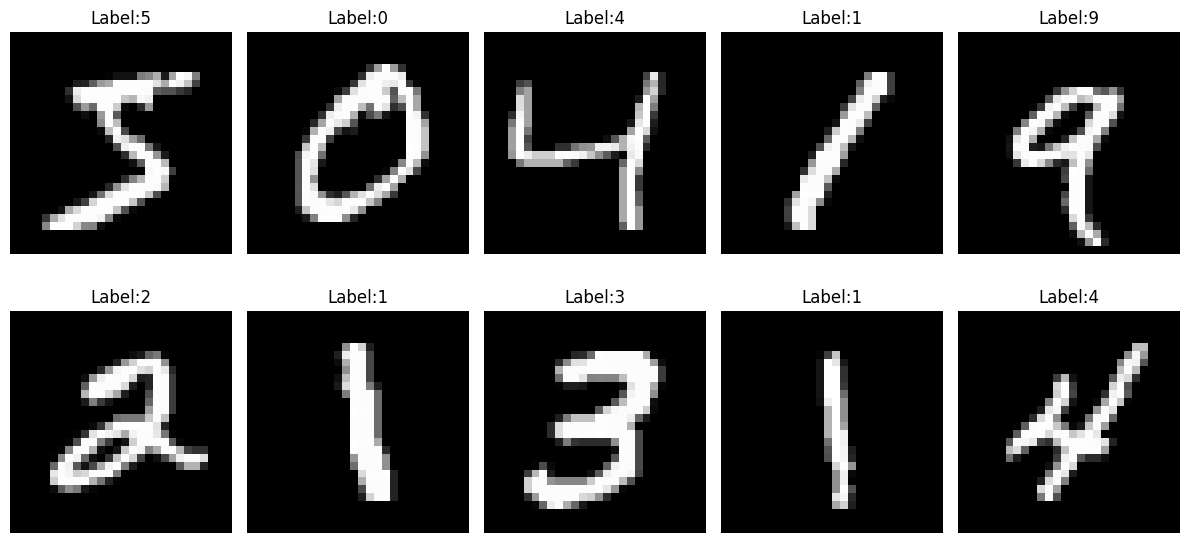

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(10):
    image, label = train_dataset[i]

    image_np = image.squeeze().numpy()

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image_np, cmap='gray')
    axes[row, col].set_title(f"Label:{label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Data preporation
Neural networks work better with batched data
We can use DataLoader to group images into batches and shuffle them

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4
)

Neurons!

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()

        # Convert image from 28x28 to a 784 element vector
        self.flatten = nn.Flatten() 
        # Fully connected layer 784in 128out
        self.fc1 = nn.Linear(in_features=784, out_features=128)
        # Fully connected layer 128in 64out
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        # Output layer 64in 10out
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        # Activation function
        self.relu = nn.ReLU()

        # Dropout for regularisation/overfit prevention
        self.dropout = nn.Dropout(p=0.2) # 20% of neurons set to 0

    def forward(self, x):
        x = self.flatten(x)

        # Run through first layer
        x = self.fc1(x)     # Run through first layer
        x = self.relu(x)    # Apply ReLU: negative values become 0
        x = self.dropout(x) # Randomly set some neurons to 0 

        # Second layer
        x = self.fc2(x)
        x = self.relu(x)

        # Output layer
        x = self.fc3(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)



In [6]:
model = SimpleNeuralNetwork()
print(model)
print(f"Number of parameters:{model.count_parameters()}")

SimpleNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of parameters:109386


In [7]:
# Testing the network works
batch = 5
fake_images = torch.randn(batch, 1, 28, 28)

model.eval()
with torch.no_grad():
    output = model(fake_images)

print(f"Output shape: {output.shape}")
print(f"Output: {output[0]}")
print(f"Prediction: {(torch.argmax(output[0])).item()}")

Output shape: torch.Size([5, 10])
Output: tensor([-0.1641,  0.0432,  0.0242,  0.1114, -0.0444,  0.0238, -0.1287,  0.1369,
        -0.0026, -0.1380])
Prediction: 7


## Training Setup
Attributes of training:
1. Loss function - Evaluate how wrong our predictions is
2. Optimiser - How do we update weight to improve

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimiser, device, epoch_num):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients - effectively reset the optimiser
        optimiser.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss calculation
        loss = criterion(outputs, labels)   
        loss.backward() # Backward pass

        optimiser.step() # Update weights

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        batch_count += 1

    avg_loss = total_loss / batch_count
    avg_accuracy = total_correct/total_samples

    print(f'    Average Loss: {avg_loss:.4f}')
    print(f'    Average accuracy: {avg_accuracy:.4f} ({total_correct}/{total_samples})')

    return avg_loss, avg_accuracy

def evaluate_model(model, test_loader, criterion, device):
    # Put model in evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    batch_count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # repeat training steps -- Probably a way to improve this
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            batch_count += 1

    avg_loss = total_loss / batch_count
    avg_accuracy = total_correct/total_samples

    print(f'    Average Loss: {avg_loss:.4f}')
    print(f'    Average accuracy: {avg_accuracy:.4f} ({total_correct}/{total_samples})')

    return avg_loss, avg_accuracy

In [ ]:
import torch.optim as optim

def train(model, train_loader, test_loader, num_epoch=10, learning_rate=0.001):
    # Define the device where the training will take place CPU vs GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimiser
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss':[],
        'train_accuracy':[],
        'test_loss':[],
        'test_accuracy': []
    }

    for epoch in range(1, num_epoch + 1):
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch}/{num_epoch}")
        print(f"{'='*50}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimiser, device, epoch
        )

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)

        print(f"Train → Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Test  → Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        if epoch != 1:
            print(f"Accuracy delta: {(test_acc - history['test_accuracy'][-2]):.4f}")

    print(f"Training complete with final accuracy: {history['test_accuracy'][-1]:.4f}")

    return model, history

In [ ]:
trained_model, history = train(model, train_loader, test_loader)


EPOCH 1/10


KeyboardInterrupt: 

## Saving our models
This model took almost 10 minutes to train, in order to keep that for later but also ensure that we can go back to better versions of our model we are going to save it for later

In [8]:
import os

def save_model_weights(model, filepath, additional_info=None):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model)
    }

    if additional_info:
        save_dict.update(additional_info)

    torch.save(save_dict, filepath)

def load_model_weights(model, filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, checkpoint

def save_complete_model(model, filepath):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    torch.save(model, filepath)

def load_complete_model(filepath):
    model = torch.load(filepath, map_location='cpu')
    return model

In [ ]:
#save_model_weights(model, "saved_models/mnist_weights.pth")

In [9]:
# Load 
model = SimpleNeuralNetwork()
model, checkpoint = load_model_weights(model, "saved_models/mnist_weights.pth")

## Let's test the model

Now that the model is trained, we can put the first 5 values of the evaluation set and see what the model predicts

`image → model.eval() → torch.no_grad() → raw_outputs → softmax → probabilities → argmax → prediction`

In [10]:
def predict(model, image, device):
    # Put model in evaluation mode so it does not train
    model.eval()
    image_batch = image.to(device)

    with torch.no_grad():
        raw_outputs = model(image_batch)
        probabilities = torch.softmax(raw_outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
        all_probs = probabilities[0].cpu().numpy()

    return predicted_class, confidence, all_probs

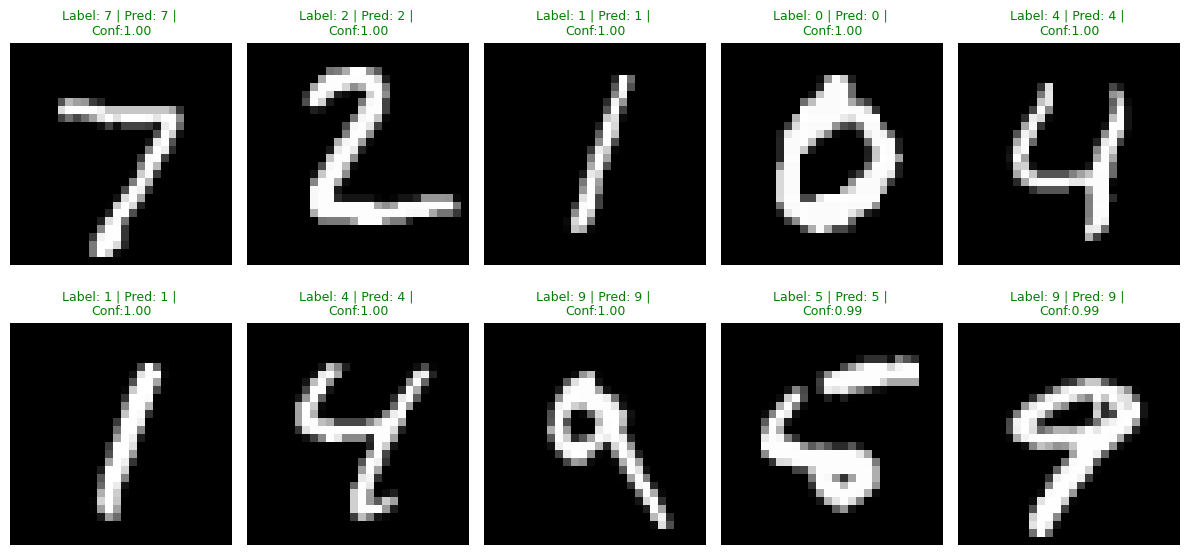

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in range(10):
    image, label = test_dataset[i]

    image_np = image.squeeze().numpy()
    predicted_class, confidence, all_probs = predict(model, image, device)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image_np, cmap='gray')

    if predicted_class == label:
        title_color = 'green'
    else:
        title_color = 'red'
    title = f"Label: {label} | Pred: {predicted_class} | \nConf:{confidence:.2f}"
    axes[row, col].set_title(title, color=title_color, fontsize=9)
    axes[row, col].axis('off')
    #print(all_probs)

plt.tight_layout()
plt.show()

## Interacting with the model

In order to interact with the model more meaningfully and also provide data that it truly would have never seen before, we are going to make a user interface on which I can write my own numbers

This interface needs to be 28x28 in order to match the expected input size of the model and ideally it is also in gray scale.
The process will look like this:

`Canvas → PIL Image → Grayscale → Resize → Normalize → Tensor → Prediction`

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from ipycanvas import Canvas, hold_canvas
from IPython.display import clear_output
import numpy as np
import torch

class MNISTDrawingInterface:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval() # Put model in evaluation mode

        self.canvas_size = 140
        self.model_size = 28

        self.setup_interface()

    def setup_interface(self):
        self.canvas = Canvas(width=self.canvas_size, height=self.canvas_size, sync_image_data=True)
        self.canvas.fill_style = 'black'
        self.canvas.fill_rect(0, 0, self.canvas_size, self.canvas_size)

        # Draw settings
        self.is_drawing = False
        self.canvas.stroke_style = 'white'
        self.canvas.line_width = 15

        # Set up mouse/touch
        self.canvas.on_mouse_down(self.start_drawing)
        self.canvas.on_mouse_move(self.draw)
        self.canvas.on_mouse_up(self.stop_drawing)

        # Buttons 
        self.predict_button = widgets.Button(
            description = 'Predict Digit',
            button_style = 'primary',
            layout=widgets.Layout(width='150px', height='40px')
        )

        self.clear_button = widgets.Button(
            description='Clear Canvas',
            button_style='warning',
            layout=widgets.Layout(width='150px', height='40px')
        )

        # Button callbacks
        self.predict_button.on_click(self.predict_digit)
        self.clear_button.on_click(self.clear_canvas)

        self.output = widgets.Output()

        self.info_label = widgets.HTML(
            value="MNIST prediction canvas"
        )

    def start_drawing(self, x, y):
        self.is_drawing=True
        self.canvas.begin_path()
        self.canvas.move_to(x,y)

    def draw(self, x, y):
        if self.is_drawing:
            self.canvas.line_to(x, y)
            self.canvas.stroke()

    def stop_drawing(self, x, y):
        self.is_drawing = False

    def clear_canvas(self, button):
        with hold_canvas(self.canvas):
            self.canvas.clear()
            self.canvas.fill_style = 'black'
            self.canvas.fill_rect(0, 0, self.canvas_size, self.canvas_size)

        with self.output:
            clear_output()

    def canvas_to_mnist(self):
        # Canvas to image
        canvas_data = self.canvas.get_image_data(0, 0, self.canvas_size, self.canvas_size)
        # Convert to numpy
        img_array = np.array(canvas_data, dtype=np.uint8)
        # Reshape
        img_array = img_array.reshape((self.canvas_size, self.canvas_size, 4))

        img = Image.fromarray(img_array, 'RGBA')

        # Convert to grayscale
        img_gray = img.convert('L')

        img_resized = img_gray.resize((self.model_size, self.model_size), Image.Resampling.LANCZOS)
        img_array = np.array(img_resized)
        # Normalise between 0-1
        img_array = img_array.astype(np.float32)/255.0
        img_tensor = torch.tensor(img_array).unsqueeze(0)

        return img_tensor
        

    def predict_digit(self, button):
        with self.output:
            clear_output(wait=True)
            try:
                img_tensor = self.canvas_to_mnist()
                prediction, confidence, all_probs = self.make_prediction(img_tensor)
                self.display_prediction_results(img_tensor, prediction, confidence, all_probs)
            except Exception as e:
                print(f'Error making prediction: {e}')
    
    def make_prediction(self, img_tensor):
        img_batch = img_tensor.unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(img_batch)
            probabilities = torch.softmax(outputs, dim=1)

            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

            all_probs = probabilities[0].cpu().numpy()

        return predicted_class, confidence, all_probs
    
    def display_prediction_results(self, img_tensor, prediction, confidence, all_probs):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

        ax1.imshow(img_tensor.squeeze().numpy(), cmap='gray')
        ax1.set_title(f"Prediction: {prediction}", fontsize=12)
        ax1.axis('off')

        digits = range(10)
        bars=ax2.bar(digits, all_probs, alpha=0.7)

        # Highlight predicted digit
        bars[prediction].set_color('green')
        bars[prediction].set_alpha(1.0)

        ax2.set_xlabel('Digit')
        ax2.set_ylabel('Probability')
        ax2.set_title(f'Model Confidence for All Digits')
        ax2.set_xticks(digits)
        ax2.grid(True, alpha=0.3)

        for i, prob in enumerate(all_probs):
            if prob > 0.01:
                ax2.text(i, prob+0.01, f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()

    def display_interface(self):
        title = widgets.HTML("<h2>MNIST Digit Recognision canvas</h2>")

        button_box = widgets.HBox([
            self.predict_button,
            self.clear_button
        ], layout=widgets.Layout(justify_content='center'))

        interface= widgets.VBox([
            title, 
            self.canvas,
            widgets.HTML("<br>"),
            button_box,
            widgets.HTML("<br>"),
            self.output
        ])

        return interface


In [ ]:
interface = MNISTDrawingInterface(model, device)

In [37]:
interface.display_interface()